<a href="https://colab.research.google.com/github/klaasmeinke/CNNs-exoplanet-cartography/blob/main/Fibonacci_Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/Thesis'

%run Plotting.ipynb

Mounted at /content/drive
/content/drive/MyDrive/Thesis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis


# Spherical Convolutions

#### A function to order points by the angles they make about a central point
inputs:
- idx_points is the indices of the sorrounding points
- idx_center is the index of the center point
- points are the coordinates of each faces center


In [ ]:
def order_by_angle(idx_points, idx_center, points):

    # the position of each face relative to central face:
    center = points[idx_center]
    center /= np.linalg.norm(center)
    positions = points[idx_points] - center

    # project them into the plane containing the central triangle
    positions = positions - center * np.tensordot(positions, center,
                                                  axes = 1)[:, None]
    # create a local planar coordinate system:
    a1 = [0,0,1] - center * np.dot(center, [0,0,1]) # first axis in direction of z
    a1 /= np.linalg.norm(a1) # normalize
    a2 = np.cross(a1, center) # second axis is orthogonal to this

    # find the angle that each point makes in the local coordinate system
    angles = np.arctan2(np.tensordot(positions, a1, axes = 1),
                        np.tensordot(positions, a2, axes = 1))

    # sort the faces
    idx_points = idx_points[angles.argsort()]

    return idx_points

#### A function to change the length of a vector by removing elements or repeating them

inputs:
- the vector
- the intended length of said vector

this function takes out or repeats element as evenly as possible <br>
we assume that the vector is circular, so that the last element is also next to the first element

In [ ]:
def sample(vector, length):
    if len(vector) < length:

        steps = length - len(vector)
        idx_repeat = np.linspace(0, len(vector), steps, endpoint = False)
        idx_repeat = np.int16(np.rint(idx_repeat+1e-6))
        idx_repeat[idx_repeat > len(vector) - 1] = 0

        vector = np.insert(vector, idx_repeat, np.array(vector)[idx_repeat])

    elif len(vector) > length:
        steps = len(vector) - length
        idx_del = np.linspace(0, len(vector), steps, endpoint = False)
        idx_del = np.int16(np.rint(idx_del+1e-6))
        idx_del[idx_del > len(vector) - 1] = 0

        vector = np.delete(vector, idx_del)

    return vector

#### This Discrimates Between Points and Edges:

In [ ]:
# create an (1000, 1000) array, which counts how many vertices all other triangles
# # share with each triangle (this array is the same when transposed)
tuple_faces = np.array([[tuple(point) for point in face] for face in faces],
                 dtype = 'f,f,f') # convert coordinates to tuples
shared_vertices = [np.count_nonzero(np.isin(tuple_faces, ft, assume_unique = False),
                                    axis = 1) for ft in tuple_faces]
shared_vertices = np.array(shared_vertices)

# create a (1000,) array with indices of the central triangle
idx_center = np.array(range(1000))
idx = idx_center[:]

# create a (1000, 3) array with the indices of which triangles share two vertices:
idx_edge = np.array([np.where(row == 2)[0] for row in shared_vertices])
# order them:
idx_edge = np.array([order_by_angle(row, i, points) for row, i in
                     zip(idx_edge, range(1000))])

idx = [np.append(i, j) for i, j in zip(idx, idx_edge)]


# create a list with indices of triangles that share atleast one vertex
idx_point = [np.where(x == 1)[0] for x in shared_vertices]
idx_point = [order_by_angle(row, i, points) for row, i in
             zip(idx_point, range(1000))]

idx = [np.append(i, j) for i, j in zip(idx, idx_point)]

# # make them all be 12 long:
# idx_point = np.array([sample(row, 12) for row in idx_point])

# triangles which have an edge on a triangle which has a point on the
# # central triangle:

idx_point_edge = [[np.where(shared_vertices[idx] == 2)[0]
                   for idx in idx_point[i]] for i in range(1000)]

idx_point_edge = [np.hstack(row) for row in idx_point_edge]
idx_point_edge = [np.unique(row) for row in idx_point_edge]
idx_point_edge = [row[~np.in1d(row, i)] for row, i in zip(idx_point_edge, idx)]
idx_point_edge = [order_by_angle(row, i, points) for row, i in
                 zip(idx_point_edge, range(1000))]

idx = [np.append(i, j) for i, j in zip(idx, idx_point_edge)]

# triangles which have a point on a triangle which has a point on the
# # central triangle:

idx_point_point = [[np.where(shared_vertices[idx] == 1)[0]
                   for idx in idx_point[i]] for i in range(1000)]
idx_point_point = [np.hstack(row) for row in idx_point_point]
idx_point_point = [np.unique(row) for row in idx_point_point]
idx_point_point = [row[~np.in1d(row, i)] for row, i in zip(idx_point_point, idx)]
idx_point_point = [order_by_angle(row, i, points) for row, i in
                   zip(idx_point_point, range(1000))]

idx = [np.append(i, j) for i, j in zip(idx, idx_point_point)]

37


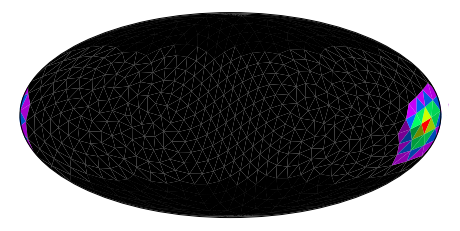

36


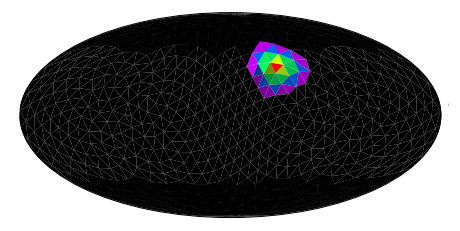

37


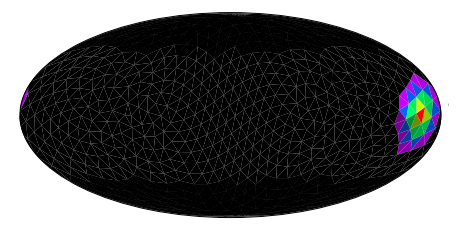

37


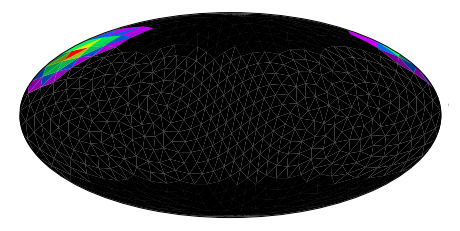

40


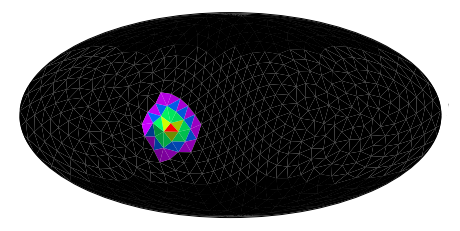

In [ ]:
sampling = 200

for i_c, i_e, i_p, i_p_e, i_p_p in zip(idx_center[::sampling],
                                       idx_edge[::sampling],
                                       idx_point[::sampling],
                                       idx_point_edge[::sampling],
                                       idx_point_point[::sampling]):
    # black background:
    colors = np.zeros((1000, 3))


    hues = np.linspace(0, 0.8, 5)

    # center:
    colors[i_c] = colorsys.hsv_to_rgb(hues[0], 1, 1)

    # one edge touching:
    colors_e = [colorsys.hsv_to_rgb(hues[1], 1, v) for v in
                np.linspace(0.55, 1, len(i_e))]
    colors[i_e] = colors_e

    # one point touching:
    colors_p = [colorsys.hsv_to_rgb(hues[2], 1, v) for v in
                np.linspace(0.55, 1, len(i_p))]
    colors[i_p] = colors_p

    # one edge touching a triangle which has a point touching:
    colors_p_e = [colorsys.hsv_to_rgb(hues[3], 1, v) for v in
                  np.linspace(0.55, 1, len(i_p_e))]
    colors[i_p_e] = colors_p_e

    # one point touching a triangle with one point touching:
    colors_p_p = [colorsys.hsv_to_rgb(hues[4], 1, v) for v in
                  np.linspace(0.55, 1, len(i_p_p))]
    colors[i_p_p] = colors_p_p

    print(1 + len(i_e) + len(i_p) + len(i_p_e)+ len(i_p_p))

    mollweide(faces, colors)
    plt.show()

#### Only Points Count:

In [ ]:
# create an (1000, 1000) array, which counts how many vertices all other triangles
# # share with each triangle (this array is the same when transposed)
tuple_faces = np.array([[tuple(point) for point in face] for face in faces],
                 dtype = 'f,f,f') # convert coordinates to tuples
shared_vertices = [np.count_nonzero(np.isin(tuple_faces, ft, assume_unique = False),
                                    axis = 1) for ft in tuple_faces]
shared_vertices = np.array(shared_vertices)

# create a (1000,) array with indices of the central triangle
idx_0 = np.array(range(1000))
idx = idx_0[:]

# triangles touching the central triangle
idx_1 = [np.where((x > 0) * (x < 3))[0] for x in shared_vertices]
idx_1 = [order_by_angle(row, i, points) for row, i in zip(idx_1, range(1000))]
idx = [np.append(i, j) for i, j in zip(idx, idx_1)]

# triangles touching a triangle touching the central triangle:
idx_2 = [[np.where((shared_vertices[idx] > 0) * (shared_vertices[idx] < 3))[0]
                   for idx in idx_1[i]] for i in range(1000)]
idx_2 = [np.hstack(row) for row in idx_2]
idx_2 = [np.unique(row) for row in idx_2]
idx_2 = [row[~np.in1d(row, i)] for row, i in zip(idx_2, idx)]
idx_2 = [order_by_angle(row, i, points) for row, i in zip(idx_2, range(1000))]
idx = [np.append(i, j) for i, j in zip(idx, idx_2)]

# triangles touching a triangle, touching a triangle, touching the central triangle:
idx_3 = [[np.where((shared_vertices[idx] > 0) * (shared_vertices[idx] < 3))[0]
                   for idx in idx_2[i]] for i in range(1000)]
idx_3 = [np.hstack(row) for row in idx_3]
idx_3 = [np.unique(row) for row in idx_3]
idx_3 = [row[~np.in1d(row, i)] for row, i in zip(idx_3, idx)]
idx_3 = [order_by_angle(row, i, points) for row, i in zip(idx_3, range(1000))]
idx = [np.append(i, j) for i, j in zip(idx, idx_3)]


# you know it:
idx_4 = [[np.where((shared_vertices[idx] > 0) * (shared_vertices[idx] < 3))[0]
                   for idx in idx_3[i]] for i in range(1000)]
idx_4 = [np.hstack(row) for row in idx_4]
idx_4 = [np.unique(row) for row in idx_4]
idx_4 = [row[~np.in1d(row, i)] for row, i in zip(idx_4, idx)]
idx_4 = [order_by_angle(row, i, points) for row, i in zip(idx_4, range(1000))]
idx = [np.append(i, j) for i, j in zip(idx, idx_4)]

idx_5 = [[np.where((shared_vertices[idx] > 0) * (shared_vertices[idx] < 3))[0]
                   for idx in idx_4[i]] for i in range(1000)]
idx_5 = [np.hstack(row) for row in idx_5]
idx_5 = [np.unique(row) for row in idx_5]
idx_5 = [row[~np.in1d(row, i)] for row, i in zip(idx_5, idx)]
idx_5 = [order_by_angle(row, i, points) for row, i in zip(idx_5, range(1000))]
idx = [np.append(i, j) for i, j in zip(idx, idx_5)]

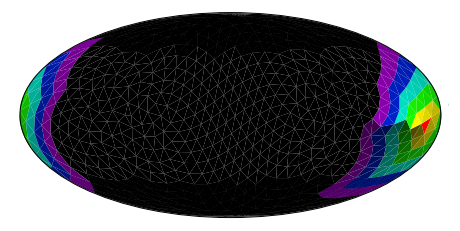

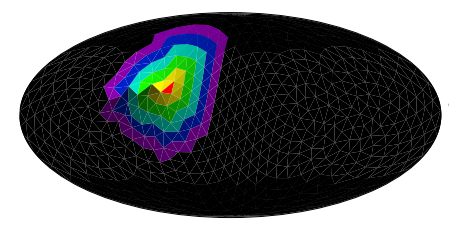

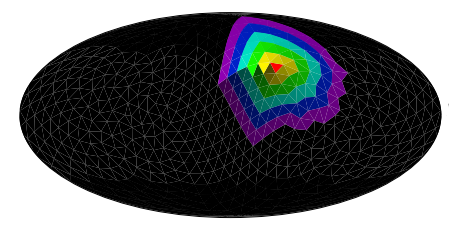

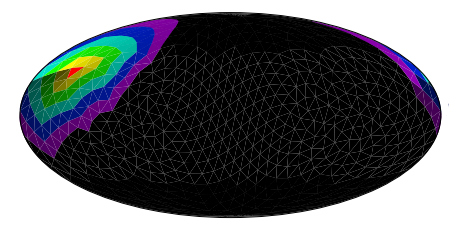

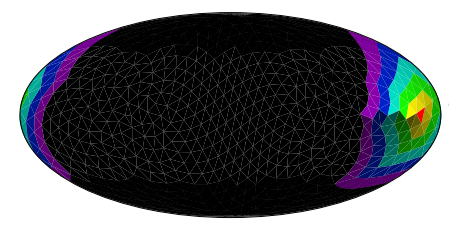

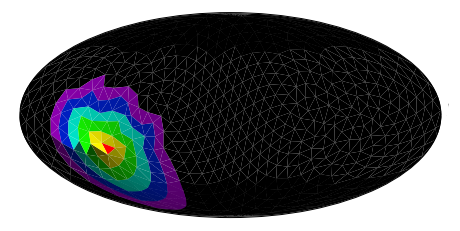

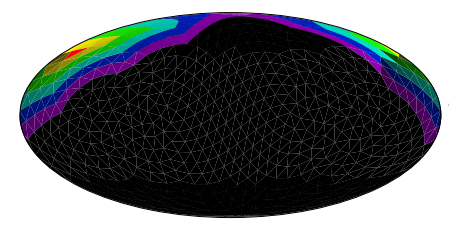

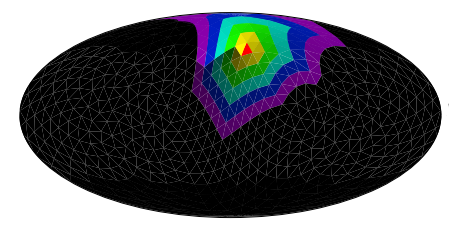

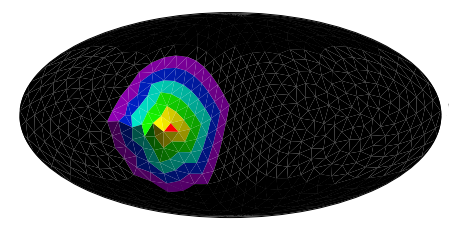

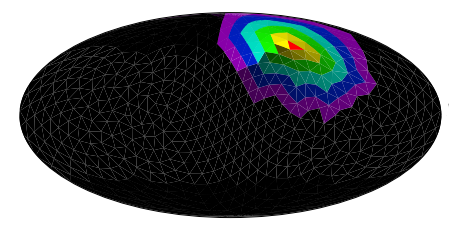

In [ ]:
sampling = 100

hues = np.linspace(0, 0.8, 6)

for i_0, i_1, i_2, i_3, i_4, i_5 in zip(idx_0[::sampling],
                                        idx_1[::sampling],
                                        idx_2[::sampling],
                                        idx_3[::sampling],
                                        idx_4[::sampling],
                                        idx_5[::sampling]):

    # black background:
    colors = np.zeros((1000, 3))

    colors[i_0] = colorsys.hsv_to_rgb(hues[0], 1, 1)

    colors_1 = [colorsys.hsv_to_rgb(hues[1], 1, v) for v in
                np.linspace(0.3, 1, len(i_1))]
    colors[i_1] = colors_1

    colors_2 = [colorsys.hsv_to_rgb(hues[2], 1, v) for v in
                np.linspace(0.3, 1, len(i_2))]
    colors[i_2] = colors_2

    colors_3 = [colorsys.hsv_to_rgb(hues[3], 1, v) for v in
                np.linspace(0.3, 0.9, len(i_3))]
    colors[i_3] = colors_3

    colors_4 = [colorsys.hsv_to_rgb(hues[4], 1, v) for v in
                np.linspace(0.3, 0.8, len(i_4))]
    colors[i_4] = colors_4

    colors_5 = [colorsys.hsv_to_rgb(hues[5], 1, v) for v in
                np.linspace(0.3, 0.7, len(i_5))]
    colors[i_5] = colors_5

    mollweide(faces, colors)
    plt.show()

12
24
35
46
56


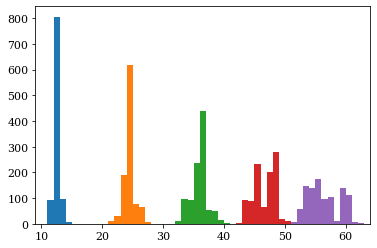

In [ ]:
for idx in [idx_1, idx_2, idx_3, idx_4, idx_5]:
    lengths = [len(i) for i in idx]
    plt.hist(lengths, bins = range(9, 64))
    print(np.int(np.rint(np.mean(lengths))))

plt.xlim([9, 64])
plt.show()

In [ ]:
idx_1 = np.array([sample(vector, 12) for vector in idx_1])
idx_2 = np.array([sample(vector, 24) for vector in idx_2])
idx_3 = np.array([sample(vector, 35) for vector in idx_3])
idx_4 = np.array([sample(vector, 46) for vector in idx_4])
idx_5 = np.array([sample(vector, 56) for vector in idx_5])

12
24
35
46
56


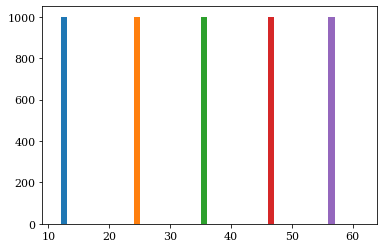

In [ ]:
for idx in [idx_1, idx_2, idx_3, idx_4, idx_5]:
    lengths = [len(i) for i in idx]
    plt.hist(lengths, bins = range(9, 64))
    print(np.int(np.rint(np.mean(lengths))))

plt.xlim([9, 64])
plt.show()

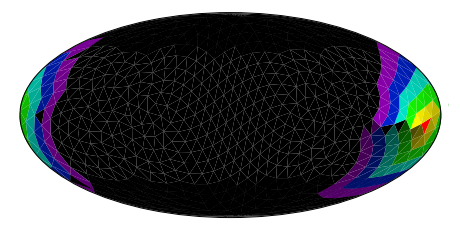

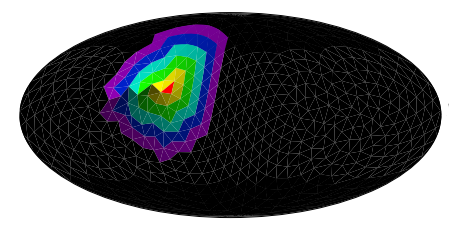

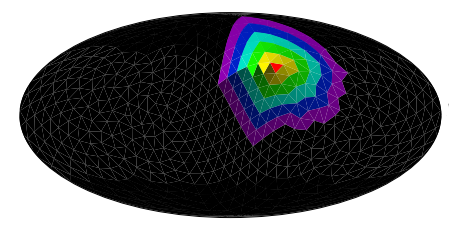

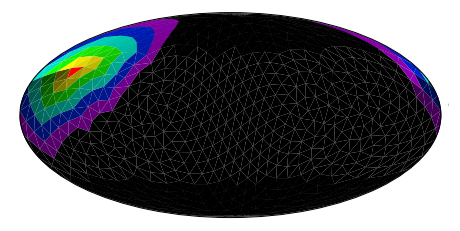

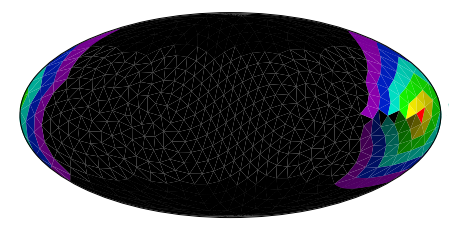

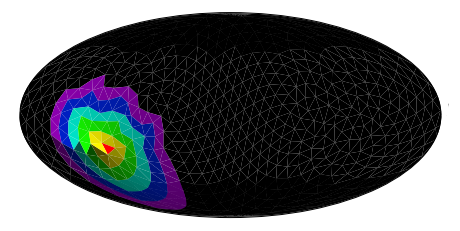

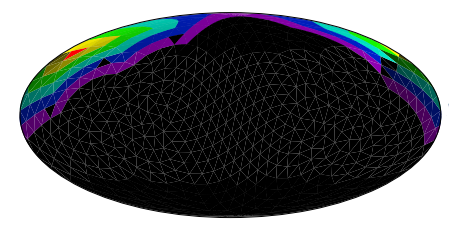

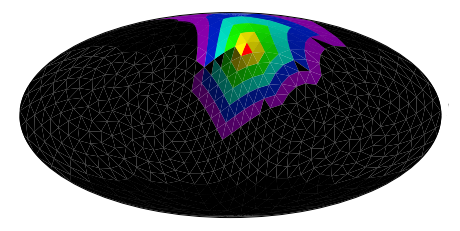

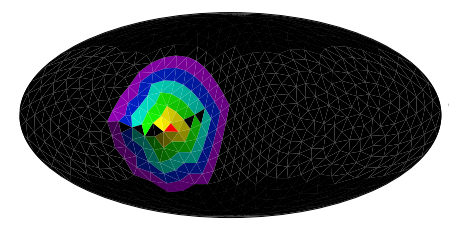

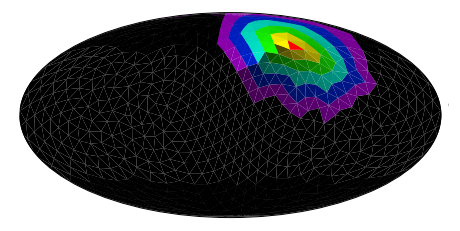

In [ ]:
sampling = 100


hues = np.linspace(0, 0.8, 6)

for i_0, i_1, i_2, i_3, i_4, i_5 in zip(idx_0[::sampling],
                                        idx_1[::sampling],
                                        idx_2[::sampling],
                                        idx_3[::sampling],
                                        idx_4[::sampling],
                                        idx_5[::sampling]):

    # black background:
    colors = np.zeros((1000, 3))

    colors[i_0] = colorsys.hsv_to_rgb(hues[0], 1, 1)

    colors_1 = [colorsys.hsv_to_rgb(hues[1], 1, v) for v in
                np.linspace(0.3, 1, len(i_1))]
    colors[i_1] = colors_1

    colors_2 = [colorsys.hsv_to_rgb(hues[2], 1, v) for v in
                np.linspace(0.3, 1, len(i_2))]
    colors[i_2] = colors_2

    colors_3 = [colorsys.hsv_to_rgb(hues[3], 1, v) for v in
                np.linspace(0.3, 0.9, len(i_3))]
    colors[i_3] = colors_3

    colors_4 = [colorsys.hsv_to_rgb(hues[4], 1, v) for v in
                np.linspace(0.3, 0.8, len(i_4))]
    colors[i_4] = colors_4

    colors_5 = [colorsys.hsv_to_rgb(hues[5], 1, v) for v in
                np.linspace(0.3, 0.7, len(i_5))]
    colors[i_5] = colors_5

    mollweide(faces, colors)
    plt.show()

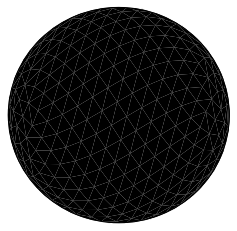

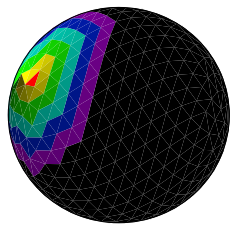

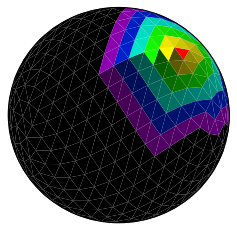

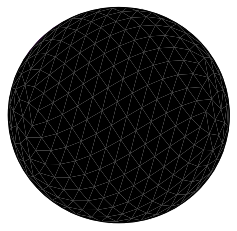

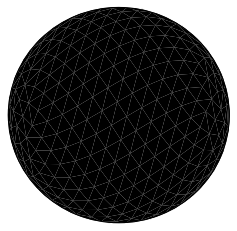

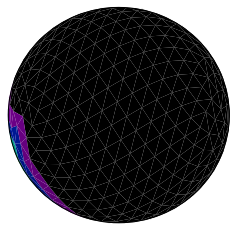

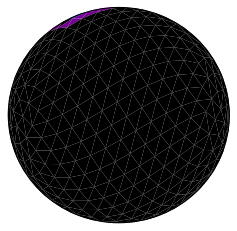

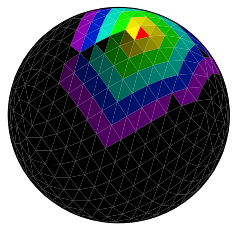

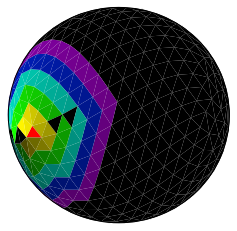

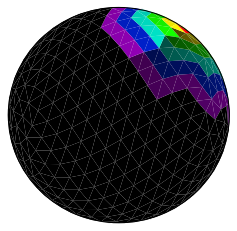

In [ ]:
sampling = 100


hues = np.linspace(0, 0.8, 6)

for i_0, i_1, i_2, i_3, i_4, i_5 in zip(idx_0[::sampling],
                                        idx_1[::sampling],
                                        idx_2[::sampling],
                                        idx_3[::sampling],
                                        idx_4[::sampling],
                                        idx_5[::sampling]):

    # black background:
    colors = np.zeros((1000, 3))

    colors[i_0] = colorsys.hsv_to_rgb(hues[0], 1, 1)

    colors_1 = [colorsys.hsv_to_rgb(hues[1], 1, v) for v in
                np.linspace(0.3, 1, len(i_1))]
    colors[i_1] = colors_1

    colors_2 = [colorsys.hsv_to_rgb(hues[2], 1, v) for v in
                np.linspace(0.3, 1, len(i_2))]
    colors[i_2] = colors_2

    colors_3 = [colorsys.hsv_to_rgb(hues[3], 1, v) for v in
                np.linspace(0.3, 0.9, len(i_3))]
    colors[i_3] = colors_3

    colors_4 = [colorsys.hsv_to_rgb(hues[4], 1, v) for v in
                np.linspace(0.3, 0.8, len(i_4))]
    colors[i_4] = colors_4

    colors_5 = [colorsys.hsv_to_rgb(hues[5], 1, v) for v in
                np.linspace(0.3, 0.7, len(i_5))]
    colors[i_5] = colors_5

    plot_disk(faces, colors)
    plt.show()

1
13
37
72
118
174


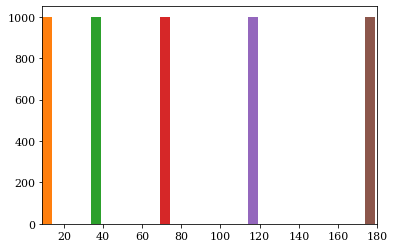

In [ ]:
# idx_0 = np.array([[i] for i in idx_0])
# idx_1 = np.append(idx_0, idx_1, axis = 1)
# idx_2 = np.append(idx_1, idx_2, axis = 1)
# idx_3 = np.append(idx_2, idx_3, axis = 1)
# idx_4 = np.append(idx_3, idx_4, axis = 1)
# idx_5 = np.append(idx_4, idx_5, axis = 1)

for idx in [idx_0, idx_1, idx_2, idx_3, idx_4, idx_5]:
    lengths = [len(i) for i in idx]
    plt.hist(lengths, bins = range(9, 180, 5))
    print(np.int(np.rint(np.mean(lengths))))

plt.xlim([9, 180])
plt.show()

Text(0, 0.5, 'facets')

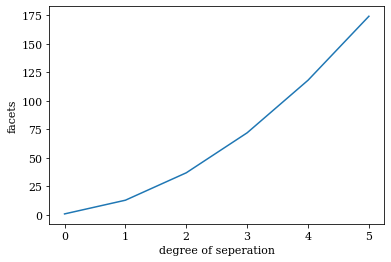

In [ ]:
plt.plot([0,1,2,3,4,5], [1, 13, 37, 72, 118, 174])
plt.xlabel('degree of seperation')
plt.ylabel('facets')
# plt.grid()

In [ ]:
np.save('data/fib_convolutions/idx_1', np.int32(idx_1))
np.save('data/fib_convolutions/idx_2', np.int32(idx_2))
np.save('data/fib_convolutions/idx_3', np.int32(idx_3))
np.save('data/fib_convolutions/idx_4', np.int32(idx_4))
np.save('data/fib_convolutions/idx_5', np.int32(idx_5))

# UpSampling

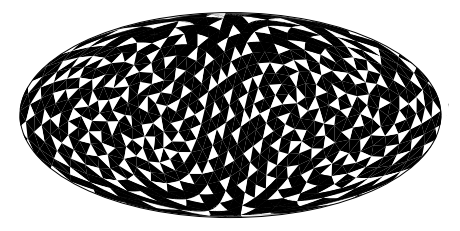

In [ ]:
points = np.load('data/points.npy')
N = 250

starting_point_ind = np.random.randint(0, len(points))

idx = np.zeros(N, dtype = np.int32)
idx[0] = starting_point_ind

for i in range(1, N):
    distancesToClosestPoints = np.array(np.zeros(len(points)), dtype=float)

    for j, point in enumerate(points):
        distancesToEstablishedPoints = np.linalg.norm(point - points[idx[:i]],
                                                      axis=1)
        distancesToClosestPoints[j] = distancesToEstablishedPoints.min()

    idx[i] = distancesToClosestPoints.argmax()

colors = np.zeros(1000)
colors[idx] = 1

mollweide(faces, colors, blackwhite = True)

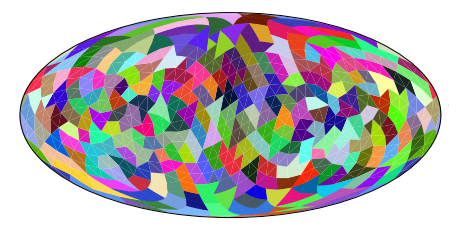

In [ ]:
closest_points = [np.argmin(np.linalg.norm(point - points[idx], axis = 1))
                 for point in points]
color_idx = np.random.rand(1000,3)
colors = [color_idx[i] for i in closest_points]

mollweide(faces, colors)